In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,f1_score

In [2]:
fraud = pd.read_csv("E:/ExcelR/Assignments/Data Science Assignments/14.Decision Trees/Fraud_check.csv")
fraud.rename(columns={"Marital.Status":"Marital_Status","Taxable.Income":"Taxable_Income",
                        "City.Population":"City_Population","Work.Experience":"Work_Experience"},inplace=True)
fraud.head()

,Undergrad,Marital_Status,Taxable_Income,City_Population,Work_Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital_Status   600 non-null    object
 2   Taxable_Income   600 non-null    int64 
 3   City_Population  600 non-null    int64 
 4   Work_Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
fraud.describe()

,Taxable_Income,City_Population,Work_Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [5]:
#Creating a new Column for categorical taxable income value
fraud["taxable_income"]="Risky"
fraud.loc[fraud["Taxable_Income"]>=30000,"taxable_income"]="Good"
fraud.drop(["Taxable_Income"],axis=1,inplace=True)
print(fraud.shape)
fraud.head()

(600, 6)


,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_income
0,NO,Single,50047,10,YES,Good
1,YES,Divorced,134075,18,YES,Good
2,NO,Married,160205,30,YES,Good
3,YES,Single,193264,15,YES,Good
4,NO,Married,27533,28,NO,Good


In [6]:
# applying lable encoder to taxable_income column and One Hot Encoding for other
label_encoder = preprocessing.LabelEncoder()
fraud["taxable_income"] = label_encoder.fit_transform(fraud["taxable_income"])
fraud = pd.get_dummies(fraud)
print(fraud.shape)
fraud.head()

(600, 10)


,City_Population,Work_Experience,taxable_income,Undergrad_NO,Undergrad_YES,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Urban_NO,Urban_YES
0,50047,10,0,1,0,0,0,1,0,1
1,134075,18,0,0,1,1,0,0,0,1
2,160205,30,0,1,0,0,1,0,0,1
3,193264,15,0,0,1,0,0,1,0,1
4,27533,28,0,1,0,0,1,0,1,0


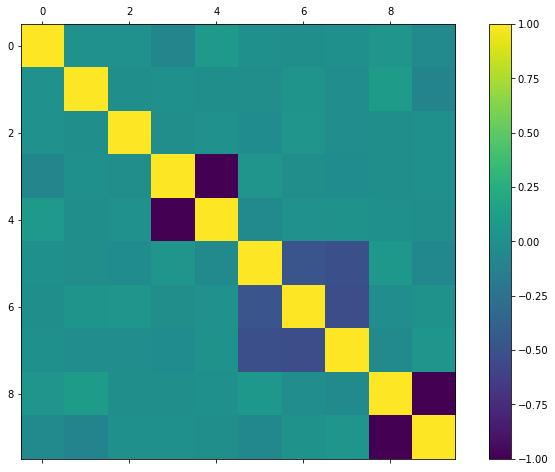

In [7]:
# correlation matrix
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(fraud.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

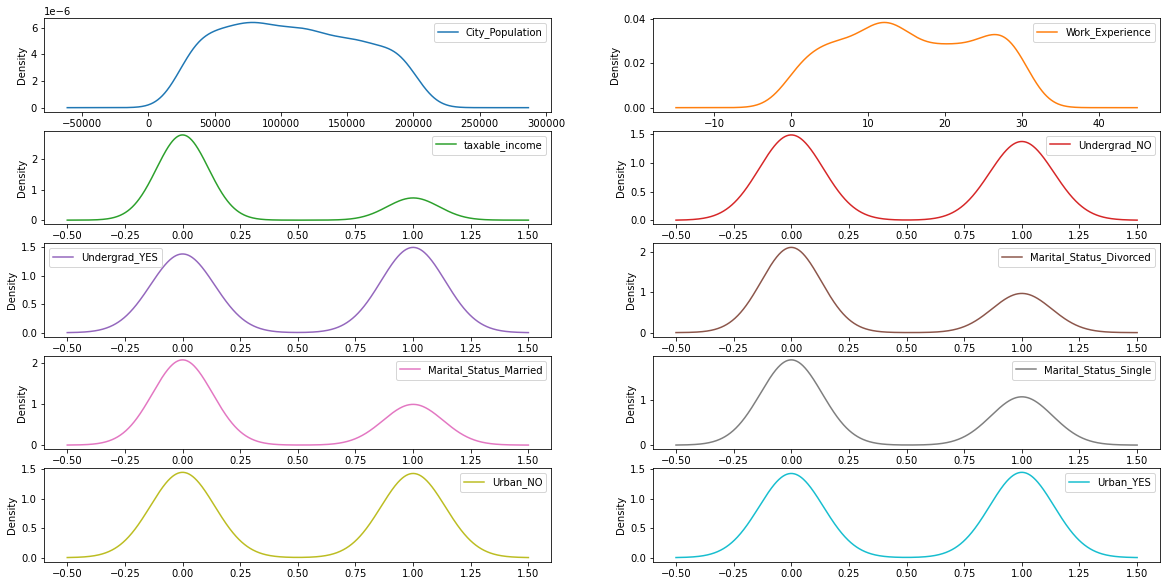

In [8]:
fraud.plot(kind="kde", subplots=True, layout=(5,2),sharex=False,figsize=(20,10))
plt.show()

In [9]:
# seprating x and y(class) variables 
X= pd.concat([fraud.iloc[:,0:2],fraud.iloc[:,3:]],axis = 1)
Y= fraud.iloc[:,2]

In [10]:
# Risky: 1 & Good: 0
Y.value_counts()

0    476
1    124
Name: taxable_income, dtype: int64

In [11]:
# Splitting data into training and testing data set
seed = 7
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.30,random_state=seed)

In [12]:
#applying DT classifier with criteria and depth on train models
model = DecisionTreeClassifier(random_state=seed)
model.fit(X_train,Y_train);

In [13]:
#grid search for hyper parameter
param_dict={"criterion":["entropy","gini"],"max_depth":range(1,15),"max_features":["auto","sqrt","log2"]}
grid = GridSearchCV(model,param_grid=param_dict,cv=10)
grid.fit(X_train,Y_train)
grid.best_params_,grid.best_score_

({'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'},
 0.7952380952380953)

In [14]:
# applying DT classifier with criteria and depth on train models based on GridSearchCV Results
model = DecisionTreeClassifier(criterion = "entropy",max_depth=5,max_features="auto")
model.fit(X_train,Y_train);

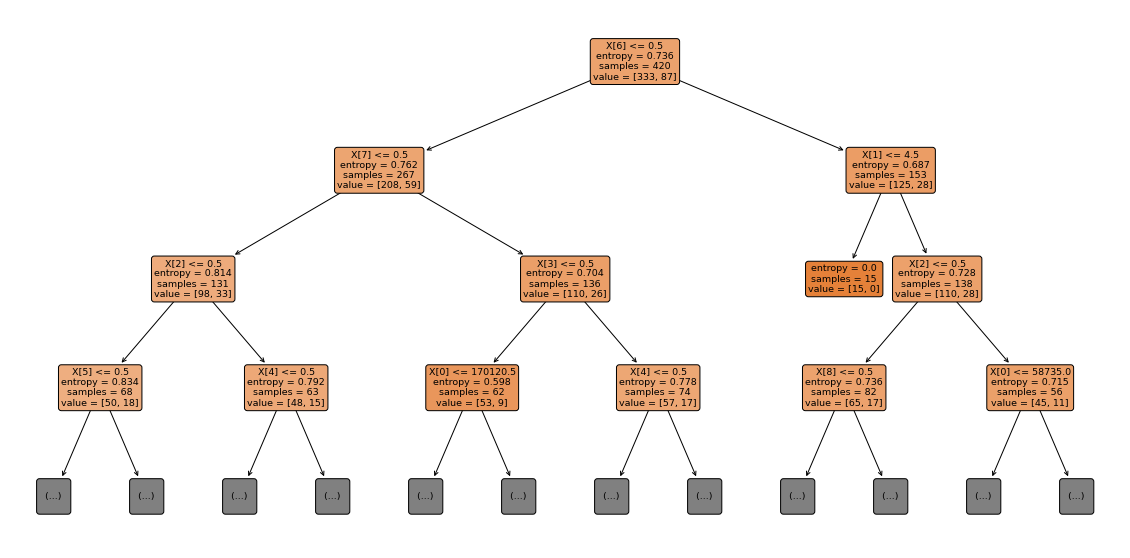

In [15]:
fig, axes = plt.subplots(figsize = (20,10))
tree.plot_tree(model,max_depth=3,rounded=True,filled =True);

In [16]:
#Predicting on test data
preds = model.predict(X_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    176
1      4
dtype: int64

In [17]:
#Getting the 2 way table to understand the correct and wrong predictions -- Confusion Matrix
pd.crosstab(Y_test,preds)

col_0,0,1
taxable_income,,
0,140,3
1,36,1


In [18]:
results = cross_val_score(model, X, Y, cv=10)
matrix = f1_score(Y_test, preds)
print("Mean cross_val_score -",round(results.mean()*100,2),"%",
      "\nY_test Accuracy - ",round(np.mean(preds==Y_test)*100,2),"%")

Mean cross_val_score - 77.5 % 
Y_test Accuracy -  78.33 %


**since the ratio of taxable income which is good and risky is uneven so less depth will prune the tree to pure nodes**